## Replicating the Dow Jones Industrial Average Index 

-Outputs seen at the bottom of the ipynb file

In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from cProfile import label
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import math


Bad key text.latex.preview in file c:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\rudra\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
# Import Index Holdings data - data pulled from WRDS manually
dow_holdings = pd.read_csv("dow_holdings.csv")

In [3]:
# Filter for only Dow index data
dow_holdings = dow_holdings[dow_holdings['indexcat'] == "DOW"]

In [4]:
# Filter for only Dow 30 index data
dow_holdings = dow_holdings[dow_holdings["conm"] == "Dow Jones Industrials-30 Stk"]

In [5]:
# For all current holdings, make end date to 1/1/2022, end of analysis
dow_holdings["thru"].fillna(20220101, inplace=True)

In [6]:
dow_holdings.head()

,gvkey,gvkeyx,from,thru,conm,tic,indexcat,co_conm,co_tic,co_naics
0,5047,5,19071107,20180625.0,Dow Jones Industrials-30 Stk,I0005,DOW,GENERAL ELECTRIC CO,GE,999977
1,4503,5,19281001,20200828.0,Dow Jones Industrials-30 Stk,I0005,DOW,EXXON MOBIL CORP,XOM,324110
2,3144,5,19320526,20220101.0,Dow Jones Industrials-30 Stk,I0005,DOW,COCA-COLA CO,KO,312111
3,6066,5,19320526,20220101.0,Dow Jones Industrials-30 Stk,I0005,DOW,INTL BUSINESS MACHINES CORP,IBM,519130
4,8762,5,19320526,20220101.0,Dow Jones Industrials-30 Stk,I0005,DOW,PROCTER & GAMBLE CO,PG,325611


In [7]:
# Filter for holdings that were removed after 12/31/2011 and current
dow_holdings = dow_holdings[dow_holdings["thru"] >= 20111231]

In [8]:
# Get time frame and information of each holding
dow_holdings = dow_holdings[['from', 'thru', 'co_conm', "co_tic"]]

In [9]:
# If holdings were there before 12/31/2011, consider them to start at beginning of analysis
dow_holdings["from"] = dow_holdings['from'].apply(lambda x: x if x >= 20111231 else 20111231)

In [10]:
dow_holdings

,from,thru,co_conm,co_tic
0,20111231,20180625.0,GENERAL ELECTRIC CO,GE
1,20111231,20200828.0,EXXON MOBIL CORP,XOM
2,20111231,20220101.0,COCA-COLA CO,KO
3,20111231,20220101.0,INTL BUSINESS MACHINES CORP,IBM
4,20111231,20220101.0,PROCTER & GAMBLE CO,PG
5,20111231,20170831.0,DU PONT (E I) DE NEMOURS,DD.2
6,20111231,20130922.0,ALCOA INC,AA.3
7,20111231,20200828.0,RAYTHEON TECHNOLOGIES CORP,RTX
8,20111231,20220101.0,3M CO,MMM
9,20111231,20220101.0,MERCK & CO,MRK


In [11]:
# Construct string of holdings used to query WRDS
" ".join(dow_holdings["co_tic"].tolist())

'GE XOM KO IBM PG DD.2 AA.3 RTX MMM MRK AXP MCD BA CAT DIS JNJ WMT HPQ HD INTC MSFT T JPM VZ PFE CVX BAC MDLZ CSCO TRV UNH NKE GS V AAPL DD WBA DOW HON AMGN CRM'

In [12]:
# Import daily stock price data - data pulled from WRDS manually
stock_prices = pd.read_csv("Daily_stock_data.csv")

In [13]:
# Filter for needed information - date, ticker, company name, close price
stock_prices = stock_prices[['datadate', 'tic', 'conm', 'prccd']]

In [14]:
stock_prices

,datadate,tic,conm,prccd
0,20120103,HON,HONEYWELL INTERNATIONAL INC,55.58
1,20120104,HON,HONEYWELL INTERNATIONAL INC,55.53
2,20120105,HON,HONEYWELL INTERNATIONAL INC,55.59
3,20120106,HON,HONEYWELL INTERNATIONAL INC,55.18
4,20120109,HON,HONEYWELL INTERNATIONAL INC,55.64
...,...,...,...,...
163080,20171116,0051B,VISA INC,NaN
163081,20180215,0051B,VISA INC,NaN
163082,20180517,0051B,VISA INC,NaN
163083,20180816,0051B,VISA INC,NaN


In [15]:
# Get holdings at beginning of the year
current_holdings = dow_holdings[dow_holdings["from"] == 20111231]

In [16]:
# Checking if all holdings have available data on first date of analysis
set(list(current_holdings["co_tic"])) - set(list(stock_prices[stock_prices["datadate"] == 20120103]["tic"]))

set()

In [17]:
# Get tickers of current holdings
current_tickers = current_holdings["co_tic"]

In [18]:
# Set up date information
current_date = dt.date(2011, 12, 31)
end_date = dt.date(2021,12,31)
current_quarter = (current_date.month-1)//3 + 1

# Flag for reconstituting
reconst = False

# Dictionary of weights to be filled
weights = dict()

# Find next date to switch holdings
next_holding_index = 30
next_holding_date = datetime.strptime(str(dow_holdings.iloc[next_holding_index]["from"]), '%Y%m%d').date()

# Get current holding data
current_tickers = current_holdings["co_tic"].values
current_data = stock_prices[stock_prices["tic"].isin(current_tickers)]

# Store lists of staged changes to holdings
leaving_companies = None
entering_companies = None


# Create dataframe for security weights at each date
sec_weights = pd.DataFrame()


# Create running list of replicated prices
dow_prices = []



while current_date < end_date:
     # Iterate through each date
     current_date = current_date + dt.timedelta(days=1)

     # If the current date is past the date that the dow changed holdings, set reconstitute next year flag
     if current_date >= next_holding_date:
          print("need to reconst")
          print(current_date)
          reconst = True
          
          # Leaving companies are stated 1 day before holding date
          leaving_companies = dow_holdings[dow_holdings["thru"] == int((next_holding_date - dt.timedelta(days=1)).strftime("%Y%m%d"))]
          
          # If today is Monday look at Friday for leaving companies
          if leaving_companies.shape[0] == 0:
               leaving_companies = dow_holdings[dow_holdings["thru"] == int((next_holding_date - dt.timedelta(days=3)).strftime("%Y%m%d"))]

          # Get entering companies
          entering_companies = dow_holdings[dow_holdings["from"] == int((next_holding_date).strftime("%Y%m%d"))]

          # Find the next date for holdings to change - will be entered if 2 or more companies were added at once
          while next_holding_index < dow_holdings.shape[0]-1 and next_holding_date == datetime.strptime(str(dow_holdings.iloc[next_holding_index]["from"]), '%Y%m%d').date():
               
               next_holding_index+=1

          # If there are no more changes to the dow til end of analysis     
          if next_holding_index == (dow_holdings.shape[0]-1):
               # Set next holding date to end of analysis date, 01/01/2022
               next_holding_date = datetime.strptime(str(20220101), '%Y%m%d').date()
          
          # Else get the next change date
          else:
               next_holding_date = datetime.strptime(str(dow_holdings.iloc[next_holding_index]["from"]), '%Y%m%d').date()
          
     # Assume we are reconstitute on the first day of each year, reconstitute if flag set
     if reconst and current_date.day == 1 and current_date.month ==1 :
          print("reconst")
          print(current_date)

          # Remove companies that are leaving the dow
          remove_list = [tick for tick in current_tickers if tick not in leaving_companies["co_tic"].values]
          # Add new companies that are entering the dow
          new_tickers = remove_list + list(entering_companies["co_tic"])
          
          # Make sure there are only 30 companies in the our holdings
          try:
               assert(len(new_tickers) == 30)
          except AssertionError:
               # Special Case: DD.2 changes to DD mid year, remove DD to maintain DD.2 only for this iteration, will be updated on date of switch
               if "DD" in new_tickers:
                    new_tickers.remove("DD")
               

          current_tickers = new_tickers
          assert(len(current_tickers) == 30)
          
          # Get data only for our holdings
          current_data = stock_prices[stock_prices["tic"].isin(current_tickers)]
          reconst = False
          

          

     # Rebalance every quarter - if current date's quarter is not yesterdays' quarter, rebalance
     if current_quarter != (current_date.month-1)//3 + 1:
          # Update quarter
          current_quarter = (current_date.month-1)//3 + 1
          print("rebalancing")
          print(current_date)

          # Get holding date of today
          today_data = current_data[current_data["datadate"] == int(current_date.strftime("%Y%m%d"))]
          
          # If today doesn't have any data, then we are in a holiday or weekend 
          while today_data.shape[0] == 0:
               # Keep adding days til we get to a trading day
               current_date = current_date + dt.timedelta(days=1)
               today_data = current_data[current_data["datadate"] == int(current_date.strftime("%Y%m%d"))]
          
          # Get total sum of price of a share of each holding
          total_price = today_data["prccd"].sum()
          # Cumulative weight for checking
          cum_weight = 0
          # Get weight of each holding based on it's price
          for i, row in today_data.iterrows():
               weights[row["tic"]] = row["prccd"]/total_price
               cum_weight += row["prccd"]/total_price

          # Zero out all weights of tickers that are not in current holdings
          zero_weights = list(set(list(dow_holdings["co_tic"])) - set(current_tickers))
          for tick in zero_weights:
               weights[tick] = 0
          
          # Check that all weights add up to 1
          assert (cum_weight > 1*.0001)
     

     # Current Price Calculation
     
     # Get today's data
     today_data = current_data[current_data["datadate"] == int(current_date.strftime("%Y%m%d"))]

     # If we have less than 30 tickers because of DD.2 switching to DD mid year, switch in current tickers
     if today_data.shape[0] < 30 and today_data.shape[0] != 0:
          if "DD.2" in current_tickers:
               current_tickers.remove('DD.2')
               current_tickers.append("DD")
          # Get data again with DD now
          current_data = stock_prices[stock_prices["tic"].isin(current_tickers)]
          today_data = current_data[current_data["datadate"] == int(current_date.strftime("%Y%m%d"))]

     # If not holiday or weekend
     if today_data.shape[0] != 0:
          today_dow_price = 0
          # For each ticker in holdings
          for ticker in current_tickers:
               # Get the current price of that ticker
               try:
                    current_ticker_price = (today_data[today_data["tic"] == ticker]["prccd"]).values[0]
               except IndexError:
                    # If it does not exist, debug here
                    break
               # Assumption: If DD weight is 0 cause mid quarter, use DD.2 weight for this quarter
               if ticker == "DD" and weights[ticker] == 0:
                    today_dow_price += current_ticker_price * weights["DD.2"]
               else:
                    # Add the ticker weighted price to overall price
                    today_dow_price += current_ticker_price * weights[ticker]
          
          # Add today price to list of prices
          dow_prices.append((current_date.strftime('%Y%m%d'), today_dow_price))

          # Add new row of date and weights of each holding on that date
          new_row = pd.DataFrame.from_dict({key:[weights[key]] for key in weights.keys()})
          new_row.index = [current_date.strftime('%Y%m%d')]

          sec_weights = sec_weights.append(new_row)
          
     
     
     # Debug statment, print beginning of each month
     if current_date.day == 1: 
          print(current_date)



rebalancing
2012-01-01
2012-02-01
2012-03-01
rebalancing
2012-04-01
2012-05-01
2012-06-01
rebalancing
2012-07-01
2012-08-01
2012-09-01
need to reconst
2012-09-24
rebalancing
2012-10-01
2012-10-01
2012-11-01
2012-12-01
reconst
2013-01-01
rebalancing
2013-01-01
2013-02-01
2013-03-01
rebalancing
2013-04-01
2013-04-01
2013-05-01
2013-06-01
rebalancing
2013-07-01
2013-07-01
2013-08-01
2013-09-01
need to reconst
2013-09-23
rebalancing
2013-10-01
2013-10-01
2013-11-01
2013-12-01
reconst
2014-01-01
rebalancing
2014-01-01
2014-02-01
2014-03-01
rebalancing
2014-04-01
2014-04-01
2014-05-01
2014-06-01
rebalancing
2014-07-01
2014-07-01
2014-08-01
2014-09-01
rebalancing
2014-10-01
2014-10-01
2014-11-01
2014-12-01
rebalancing
2015-01-01
2015-02-01
2015-03-01
need to reconst
2015-03-19
rebalancing
2015-04-01
2015-04-01
2015-05-01
2015-06-01
rebalancing
2015-07-01
2015-07-01
2015-08-01
2015-09-01
rebalancing
2015-10-01
2015-10-01
2015-11-01
2015-12-01
reconst
2016-01-01
rebalancing
2016-01-01
2016-02-0

In [19]:
#Security weights on each date. 
sec_weights

,AA.3,AXP,VZ,BA,CAT,JPM,CVX,KO,DIS,DD.2,...,UNH,V,GS,DOW,NKE,HON,WBA,AMGN,CRM,DD
20120103,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120104,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120105,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120106,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120109,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211228,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211229,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211230,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0


In [20]:
# Security returns on each date - create init dataframe 
sec_return = pd.DataFrame()
sec_return["datadate"] = sec_weights.index
sec_return["datadate"]  = pd.to_numeric(sec_return["datadate"] )
sec_return

,datadate
0,20120103
1,20120104
2,20120105
3,20120106
4,20120109
...,...
2512,20211227
2513,20211228
2514,20211229
2515,20211230


In [21]:
lookinto = []
for ticker in dow_holdings['co_tic'].unique():
    # Get the percent change of each ticker's daily price
    temp_df = stock_prices[stock_prices["tic"]==ticker]
    temp_df["return"] = temp_df["prccd"].pct_change()
    
    # Add returns as columns
    try:
        sec_return[ticker] = temp_df["return"].values
    # If not enough rows because started or ended ticker during time frame
    except ValueError:
        # Separate into another list, isolate
        lookinto.append(ticker)
    

c:\Users\rudra\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
# For these special cases
for tick in lookinto:
    # Get the percent change of prices
    temp_df = stock_prices[stock_prices["tic"]==tick]
    temp_df[tick] = temp_df["prccd"].pct_change()
    # Merge with existing returns dataframe
    sec_return = sec_return.merge(temp_df[['datadate',tick]],on='datadate',how='left')

c:\Users\rudra\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
sec_return = sec_return.set_index('datadate')

In [24]:
# Security returns on each date. 
sec_return

,GE,XOM,KO,IBM,PG,RTX,MMM,MRK,AXP,MCD,...,V,AAPL,DD,WBA,HON,AMGN,CRM,DD.2,AA.3,DOW
datadate,,,,,,,,,,,,,,,,,,,,,
20120103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20120104,0.010893,0.000233,-0.006273,-0.004079,-0.000449,0.005224,0.008264,0.001044,-0.003100,0.005565,...,-0.017866,0.005374,0.005371,-0.006957,-0.000900,-0.005459,-0.036759,0.010965,0.023835,NaN
20120105,-0.000539,-0.003023,-0.004735,-0.004743,-0.004192,-0.009594,-0.004514,0.010433,0.011609,0.004427,...,0.007514,0.011102,0.006344,-0.003351,0.001080,0.010194,0.013233,-0.006806,-0.009524,NaN
20120106,0.005391,-0.007463,-0.006343,-0.011481,-0.002405,-0.005785,-0.005131,-0.006970,-0.010861,0.007713,...,-0.011775,0.010454,0.005972,0.011002,-0.007375,0.005434,0.023185,-0.014133,-0.021368,NaN
20120109,0.011260,0.004464,0.000000,-0.005204,0.004219,0.002706,0.005997,-0.002080,0.002486,-0.009543,...,-0.008043,-0.001586,-0.000330,0.012696,0.008336,-0.008647,-0.003067,0.008471,0.028930,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.006596,0.014258,0.007386,0.007579,0.011680,0.004005,0.009887,0.011092,0.001218,0.008611,...,0.004663,0.022975,0.016170,0.004952,0.005896,0.006166,0.020384,NaN,NaN,0.013239
20211228,0.007187,-0.003232,0.003922,0.007674,0.005371,0.009151,0.005320,0.003134,0.000122,-0.001342,...,0.001930,-0.005767,0.008019,0.013799,0.003003,0.002665,-0.011034,NaN,NaN,0.013603
20211229,-0.005352,-0.008753,0.001189,0.005429,0.008290,-0.001511,0.004335,0.001823,-0.003528,0.002277,...,0.000550,0.000502,0.001740,0.015944,0.002318,0.008106,-0.003562,NaN,NaN,0.007593


In [25]:
# Construct dataframe of replicated dow data
our_dow = pd.DataFrame(dow_prices, columns = ["date", "price"])

In [26]:
our_dow.head()

,date,price
0,20120103,79.017884
1,20120104,79.046070
2,20120105,78.880380
3,20120106,78.462288
4,20120109,78.586254


In [27]:
# Get daily returns of replicated dow
our_dow["return"] = our_dow["price"].pct_change()

In [28]:
# Set date to datetime type
our_dow["date"] = pd.to_datetime(our_dow["date"], infer_datetime_format=True)  

In [29]:
our_dow = our_dow.set_index("date")

In [30]:
#Value and return of your replicating portfolio on each date. 
our_dow

,price,return
date,,
2012-01-03,79.017884,NaN
2012-01-04,79.046070,0.000357
2012-01-05,78.880380,-0.002096
2012-01-06,78.462288,-0.005300
2012-01-09,78.586254,0.001580
...,...,...
2021-12-27,240.274678,0.010152
2021-12-28,240.849765,0.002393
2021-12-29,241.445451,0.002473


<AxesSubplot:xlabel='date'>

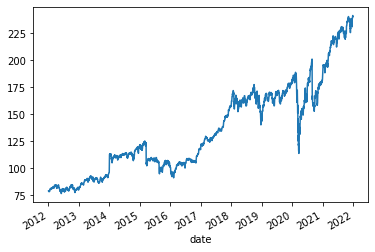

In [31]:
# See changes in price over time
our_dow["price"].plot()

# Metric Calculations 

In [32]:
# Import dow date provided by course team
real_dow = pd.read_excel("dow_data_hw1.xlsx", skiprows=3)
real_dow.head()

,Dates,Close Price,Price,Return
0,2000-08-01,10606.95,0.009524,0.008076
1,2000-08-02,10687.53,0.009434,0.007667
2,2000-08-03,10706.58,-0.000584,0.001895
3,2000-08-04,10767.75,0.005260,0.005713
4,2000-08-07,10867.01,0.010465,0.009218


In [33]:
# Rename Columns for DJI Index, DIA, and DJITR
real_dow.columns = ["Dates","Close Price", "DIA Price", "DJITR Return"]

In [34]:
# Get dates that match our analysis
real_dow = real_dow[(real_dow["Dates"]>= our_dow.index.min()) & (real_dow["Dates"]<= our_dow.index.max())]
real_dow = real_dow.set_index('Dates')

In [35]:
# Drop holidays
x = real_dow.index.difference(our_dow.index)
real_dow = real_dow.drop(x)

In [36]:
# Get the daily returns of the dow index data given
real_dow['Real Dow Returns'] =real_dow["Close Price"].pct_change()

In [37]:
# Mean normalize prices to compare replicated dow to dow Index
our_dow["norm_price"]=(our_dow["price"]-our_dow["price"].mean())/our_dow["price"].std()

In [38]:
real_dow["norm_price"]=(real_dow["Close Price"]-real_dow["Close Price"].mean())/real_dow["Close Price"].std()

In [39]:
# Calculate Cumulative Returns of both replicated dow and dow index
real_dow['Cumulative Return'] = (1 + real_dow["Real Dow Returns"]).cumprod() - 1
real_dow['Cumulative Return DIA'] = (1 + real_dow["DIA Price"]).cumprod() - 1
real_dow['Cumulative Return DJITR'] = (1 + real_dow["DJITR Return"]).cumprod() - 1
real_dow

,Close Price,DIA Price,DJITR Return,Real Dow Returns,norm_price,Cumulative Return,Cumulative Return DIA,Cumulative Return DJITR
Dates,,,,,,,,
2012-01-03,12397.38,0.014608,0.014756,NaN,-1.425019,NaN,0.014608,0.014756
2012-01-04,12418.42,0.002750,0.001960,0.001697,-1.421706,0.001697,0.017398,0.016745
2012-01-05,12415.70,-0.000161,-0.000219,-0.000219,-1.422134,0.001478,0.017234,0.016522
2012-01-06,12359.92,-0.003388,-0.003922,-0.004493,-1.430917,-0.003022,0.013788,0.012535
2012-01-09,12392.69,0.001052,0.002651,0.002651,-1.425757,-0.000378,0.014854,0.015220
...,...,...,...,...,...,...,...,...
2021-12-27,36302.38,0.009907,0.009786,0.009786,2.339246,1.928230,2.718078,2.772781
2021-12-28,36398.21,0.002948,0.002640,0.002640,2.354337,1.935960,2.729039,2.782741
2021-12-29,36488.63,0.002335,0.002484,0.002484,2.368575,1.943253,2.737746,2.792137


In [40]:
our_dow['Cumulative Return'] = (1 + our_dow["return"]).cumprod() - 1
our_dow

,price,return,norm_price,Cumulative Return
date,,,,
2012-01-03,79.017884,NaN,-1.324632,NaN
2012-01-04,79.046070,0.000357,-1.323968,0.000357
2012-01-05,78.880380,-0.002096,-1.327876,-0.001740
2012-01-06,78.462288,-0.005300,-1.337740,-0.007031
2012-01-09,78.586254,0.001580,-1.334815,-0.005462
...,...,...,...,...
2021-12-27,240.274678,0.010152,2.479659,2.040763
2021-12-28,240.849765,0.002393,2.493226,2.048041
2021-12-29,241.445451,0.002473,2.507280,2.055580


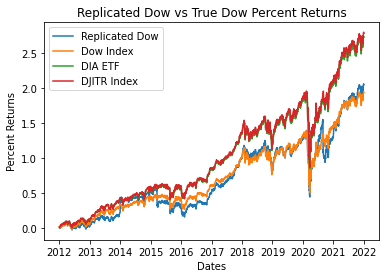

In [41]:
# Plot Percent Return
plt.plot(our_dow["Cumulative Return"], label="Replicated Dow")
plt.plot(real_dow["Cumulative Return"], label="Dow Index")
plt.plot(real_dow['Cumulative Return DIA'],label = 'DIA ETF')
plt.plot(real_dow['Cumulative Return DJITR'],label = 'DJITR Index')
plt.xlabel("Dates")
plt.ylabel("Percent Returns")
plt.title("Replicated Dow vs True Dow Percent Returns")
plt.legend()
plt.show()

In [42]:
real_dow.head()

,Close Price,DIA Price,DJITR Return,Real Dow Returns,norm_price,Cumulative Return,Cumulative Return DIA,Cumulative Return DJITR
Dates,,,,,,,,
2012-01-03,12397.38,0.014608,0.014756,NaN,-1.425019,NaN,0.014608,0.014756
2012-01-04,12418.42,0.002750,0.001960,0.001697,-1.421706,0.001697,0.017398,0.016745
2012-01-05,12415.70,-0.000161,-0.000219,-0.000219,-1.422134,0.001478,0.017234,0.016522
2012-01-06,12359.92,-0.003388,-0.003922,-0.004493,-1.430917,-0.003022,0.013788,0.012535
2012-01-09,12392.69,0.001052,0.002651,0.002651,-1.425757,-0.000378,0.014854,0.015220


In [43]:
our_dow.head()

,price,return,norm_price,Cumulative Return
date,,,,
2012-01-03,79.017884,NaN,-1.324632,NaN
2012-01-04,79.046070,0.000357,-1.323968,0.000357
2012-01-05,78.880380,-0.002096,-1.327876,-0.001740
2012-01-06,78.462288,-0.005300,-1.337740,-0.007031
2012-01-09,78.586254,0.001580,-1.334815,-0.005462


In [44]:
# Calculate Sharpe Ratio

In [45]:
# Scrape Tresury website for 10 year treasury yields
base_url = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value='

In [46]:
years = range(2012, 2022)

In [47]:
# For each year, get the treasury returns
t_df = pd.DataFrame()
for year in years:
    url = base_url + str(year)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all('table')
    df = pd.read_html(str(table))[0]
    add_df = df[["Date", "10 Yr"]]
    t_df = t_df.append(add_df)

In [48]:
t_df_copy = t_df.copy()

In [49]:
# Calculated the sharpe ratio
def get_sharpe_ratio(t_df, dow_df_org, return_col_name):
    t_df = t_df.set_index("Date")
    dow_df = dow_df_org
    t_df.index = pd.to_datetime(t_df.index)
    dow_df = dow_df.merge(t_df_copy,right_on=t_df.index, left_on=dow_df.index, how='left')
    # For any date that does not have a risk free rate, get the most previous date's risk free rate
    dow_df['10 Yr'].fillna(method='pad', inplace=True)
    # Get list of portfolio return - risk free rate
    excess_return = dow_df[return_col_name] - dow_df["10 Yr"]/100
    # Sharpe Ratio
    return dow_df[return_col_name].mean()/excess_return.std() * math.sqrt(2520)


In [50]:
#sharpe ratio calculations
print("Our Sharpe Ratio is: ", round(get_sharpe_ratio(t_df_copy, our_dow, "return"),4))
print("Real Dow Sharpe Ratio is: ",round(get_sharpe_ratio(t_df_copy, real_dow, "Real Dow Returns"),4))
print("DIA ETF Sharpe Ratio is: ",round(get_sharpe_ratio(t_df_copy, real_dow, "DIA Price"),4))
print("DJITR Sharpe Ratio is: ",round(get_sharpe_ratio(t_df_copy, real_dow, "DJITR Return"),4))

Our Sharpe Ratio is:  1.8731
Real Dow Sharpe Ratio is:  1.9917
DIA ETF Sharpe Ratio is:  2.3905
DJITR Sharpe Ratio is:  2.4064


In [51]:
#metric Calculations - Our fund 

our_dow_return = our_dow['return']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(our_dow_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"Real Dow Returns":"Dow Returns ",
                "return":"Our Fund Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['Our Fund Returns'] - return_df['Dow Returns '])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print("The Tracking error of the our index: ",TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)
correlation = return_df['Our Fund Returns'].corr(return_df['Dow Returns '])
print("The Correlation between the Our returns and the Dow returns:" ,correlation)

print("The Volaltility of the Dow Returns: ",return_df['Dow Returns '].std())
print("The Volaltility of our returns: ",return_df['Our Fund Returns'].std())


The Tracking error of the our index:  0.6556217843529003 %
The Correlation between the Our returns and the Dow returns: 0.8558879679668515
The Volaltility of the Dow Returns:  0.010506168177640024
The Volaltility of our returns:  0.012663309218106463


In [52]:
#Metric Calculations - DIA returns 

DIA_return = real_dow['DIA Price']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(DIA_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"DIA Price":"DIA Returns ",
                "Real Dow Returns":"Real Dow Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['DIA Returns '] - return_df['Real Dow Returns'])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print("The Tracking error of the DIA: ",TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)

correlation = return_df['DIA Returns '].corr(return_df['Real Dow Returns'])
print("The Correlation between the DIA returns and the Dow returns: ",correlation)

print("The Volatility of DIA: ",return_df['DIA Returns '].std())
print("The Volatility of Real Dow Returns: ",return_df['Real Dow Returns'].std())


The Tracking error of the DIA:  0.05007950330025778 %
The Correlation between the DIA returns and the Dow returns:  0.9989102495879645
The Volatility of DIA:  0.010443709100446076
The Volatility of Real Dow Returns:  0.010506168177640024


In [53]:
#metric calculations - DJITR

DIA_return = real_dow['DJITR Return']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(DIA_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"DJITR Return":"DJITR Returns ",
                "Real Dow Returns":"Real Dow Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['DJITR Returns '] - return_df['Real Dow Returns'])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print("The Tracking Error DJITR: ",TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)

correlation = return_df['DJITR Returns '].corr(return_df['Real Dow Returns'])
print("The Correlation between the DJITR and the Real Dow returns: ",correlation)

print("Volatility of DJITR: ",return_df['DJITR Returns '].std())
real_dow_std = return_df['Real Dow Returns'].std()
print("Volatility of the Real Dow: ", real_dow_std)



The Tracking Error DJITR:  0.021436317822888455 %
The Correlation between the DJITR and the Real Dow returns:  0.9998325944590184
Volatility of DJITR:  0.010505445708603825
Volatility of the Real Dow:  0.010506168177640024


In [54]:
#Find tracking error of our dow index 
our_dow_return = our_dow['return']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(our_dow_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"Real Dow Returns":"Dow Returns ",
                "return":"Our Fund Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['Our Fund Returns'] - return_df['Dow Returns '])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print(TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)

0.6556217843529003 %


,Our Fund Returns,Dow Returns,sum,sum_squared
date,,,,
2020-08-31,-0.186504,-0.007811,-1.786923e-01,3.193096e-02
2014-01-02,0.168229,-0.008163,1.763917e-01,3.111403e-02
2015-03-19,-0.160290,-0.006481,-1.538083e-01,2.365699e-02
2020-07-01,0.051089,-0.003018,5.410718e-02,2.927586e-03
2021-01-04,0.040384,-0.012500,5.288433e-02,2.796752e-03
...,...,...,...,...
2021-12-30,-0.002484,-0.002482,-2.461774e-06,6.060333e-12
2019-06-13,0.003919,0.003920,-1.206988e-06,1.456820e-12
2015-08-17,0.003877,0.003878,-1.150029e-06,1.322566e-12


In [55]:
#tracking error of the DIA returns

DIA_return = real_dow['DIA Price']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(DIA_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"DIA Price":"DIA Returns ",
                "Real Dow Returns":"Real Dow Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['DIA Returns '] - return_df['Real Dow Returns'])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print(TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)

0.05007950330025778 %


,DIA Returns,Real Dow Returns,sum,sum_squared
Dates,,,,
2020-03-24,0.110192,0.113650,-3.458385e-03,1.196043e-05
2020-03-18,-0.065958,-0.063024,-2.934218e-03,8.609637e-06
2018-04-02,-0.021748,-0.019040,-2.708133e-03,7.333986e-06
2020-02-28,-0.011417,-0.013866,2.448991e-03,5.997557e-06
2012-11-07,-0.021204,-0.023627,2.422571e-03,5.868851e-06
...,...,...,...,...
2020-01-30,0.004351,0.004350,1.169048e-06,1.366673e-12
2016-07-20,0.001942,0.001941,1.163716e-06,1.354235e-12
2013-11-21,0.006865,0.006866,-6.836566e-07,4.673863e-13


In [56]:
# DJITR
DJITR_return = real_dow['DJITR Return']
real_dow_return = real_dow['Real Dow Returns']
return_df=pd.merge(DJITR_return, real_dow_return, left_index=True, right_index=True)
return_df.rename(
    columns={"DJITR Return":"DJITR Returns ",
                "Real Dow Returns":"Real Dow Returns"}
          ,inplace=True)
return_df = return_df.dropna()

return_df['sum'] = (return_df['DJITR Returns '] - return_df['Real Dow Returns'])
return_df['sum_squared'] = (return_df['sum'].pow(2))

sum_squared = return_df['sum_squared'].sum()

TE = np.sqrt(sum_squared/2516)
print(TE*100,'%')
return_df.sort_values('sum_squared',ascending = False)

0.021436317822888455 %


,DJITR Returns,Real Dow Returns,sum,sum_squared
Dates,,,,
2013-02-13,-0.000919,-0.002553,1.634018e-03,2.670016e-06
2014-02-12,-0.000311,-0.001928,1.616505e-03,2.613089e-06
2016-11-08,0.005333,0.004006,1.327436e-03,1.762086e-06
2015-02-11,0.000897,-0.000370,1.267479e-03,1.606503e-06
2018-11-08,0.001658,0.000417,1.240892e-03,1.539814e-06
...,...,...,...,...
2013-10-09,0.001790,0.001790,-7.647262e-10,5.848062e-19
2013-07-26,0.000207,0.000207,7.244975e-10,5.248966e-19
2015-07-23,-0.006673,-0.006673,5.646731e-10,3.188557e-19


## Difference between given data and Yahoo Finance

In [ ]:
# DIA - Checking

DIA = pd.read_csv("DIA.csv")
DIA_close = DIA[['Date','Close']]
DIA_close['PCT'] = DIA_close['Close'].pct_change()
DIA_close['Cumulative Return'] = (1 + DIA_close["PCT"]).cumprod() - 1
real_dow = real_dow.reset_index()


In [62]:
# Sum of differences in percent changes
sum(real_dow['DIA Price'].sub(DIA_close['PCT'],fill_value=0))

0.2337942297808321

# Outputs:

## Security weights on each date:

In [63]:
sec_weights.to_csv("output/security_weights.csv")
sec_weights

,AA.3,AXP,VZ,BA,CAT,JPM,CVX,KO,DIS,DD.2,...,UNH,V,GS,DOW,NKE,HON,WBA,AMGN,CRM,DD
20120103,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120104,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120105,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120106,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
20120109,0.005635,0.029543,0.024256,0.045313,0.057376,0.021356,0.067383,0.042822,0.023389,0.028395,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211228,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211229,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0
20211230,0.000000,0.033362,0.010415,0.043348,0.037273,0.032056,0.020011,0.010169,0.033759,0.000000,...,0.075269,0.044203,0.072885,0.011236,0.028207,0.041362,0.008976,0.041031,0.052796,0.0


## Security returns on each date. 

In [64]:
sec_return.to_csv("output/security_returns.csv")
sec_return

,GE,XOM,KO,IBM,PG,RTX,MMM,MRK,AXP,MCD,...,V,AAPL,DD,WBA,HON,AMGN,CRM,DD.2,AA.3,DOW
datadate,,,,,,,,,,,,,,,,,,,,,
20120103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20120104,0.010893,0.000233,-0.006273,-0.004079,-0.000449,0.005224,0.008264,0.001044,-0.003100,0.005565,...,-0.017866,0.005374,0.005371,-0.006957,-0.000900,-0.005459,-0.036759,0.010965,0.023835,NaN
20120105,-0.000539,-0.003023,-0.004735,-0.004743,-0.004192,-0.009594,-0.004514,0.010433,0.011609,0.004427,...,0.007514,0.011102,0.006344,-0.003351,0.001080,0.010194,0.013233,-0.006806,-0.009524,NaN
20120106,0.005391,-0.007463,-0.006343,-0.011481,-0.002405,-0.005785,-0.005131,-0.006970,-0.010861,0.007713,...,-0.011775,0.010454,0.005972,0.011002,-0.007375,0.005434,0.023185,-0.014133,-0.021368,NaN
20120109,0.011260,0.004464,0.000000,-0.005204,0.004219,0.002706,0.005997,-0.002080,0.002486,-0.009543,...,-0.008043,-0.001586,-0.000330,0.012696,0.008336,-0.008647,-0.003067,0.008471,0.028930,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211227,0.006596,0.014258,0.007386,0.007579,0.011680,0.004005,0.009887,0.011092,0.001218,0.008611,...,0.004663,0.022975,0.016170,0.004952,0.005896,0.006166,0.020384,NaN,NaN,0.013239
20211228,0.007187,-0.003232,0.003922,0.007674,0.005371,0.009151,0.005320,0.003134,0.000122,-0.001342,...,0.001930,-0.005767,0.008019,0.013799,0.003003,0.002665,-0.011034,NaN,NaN,0.013603
20211229,-0.005352,-0.008753,0.001189,0.005429,0.008290,-0.001511,0.004335,0.001823,-0.003528,0.002277,...,0.000550,0.000502,0.001740,0.015944,0.002318,0.008106,-0.003562,NaN,NaN,0.007593


## Value and return of your replicating portfolio on each date. 

In [65]:
our_dow[["price", "return"]].to_csv("output/replicating_portfolio.csv")
our_dow[["price", "return"]]

,price,return
date,,
2012-01-03,79.017884,NaN
2012-01-04,79.046070,0.000357
2012-01-05,78.880380,-0.002096
2012-01-06,78.462288,-0.005300
2012-01-09,78.586254,0.001580
...,...,...
2021-12-27,240.274678,0.010152
2021-12-28,240.849765,0.002393
2021-12-29,241.445451,0.002473
